In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 01.01.12 00:00:00 -- 31.12.2016 23:00:00

df = pd.read_excel('el.xlsx')
df.columns = ['Date', 'MWh']
df.tail(5)

,Date,MWh
43844,19ч. 31.12.2016,196.845
43845,20ч. 31.12.2016,192.813
43846,21ч. 31.12.2016,186.841
43847,22ч. 31.12.2016,178.120
43848,23ч. 31.12.2016,166.001


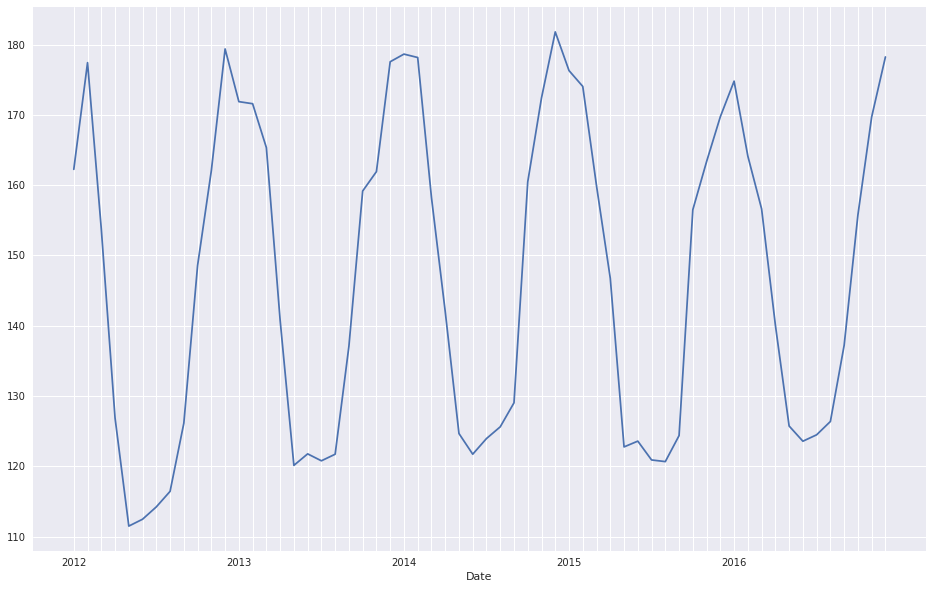

In [3]:
# string of time to timestamp convertation

df['Date'] = pd.to_datetime(df.Date, format='%Hч. %d.%m.%Y')

ts = df.set_index('Date')

ts = pd.Series(ts.MWh, index=ts.index)

mon = ts.resample('M').mean()
xt = [f'{x.month_name()} {x.year}' for x in mon.index]


ts.resample('M').mean().plot(figsize=(16, 10), xticks=xt);

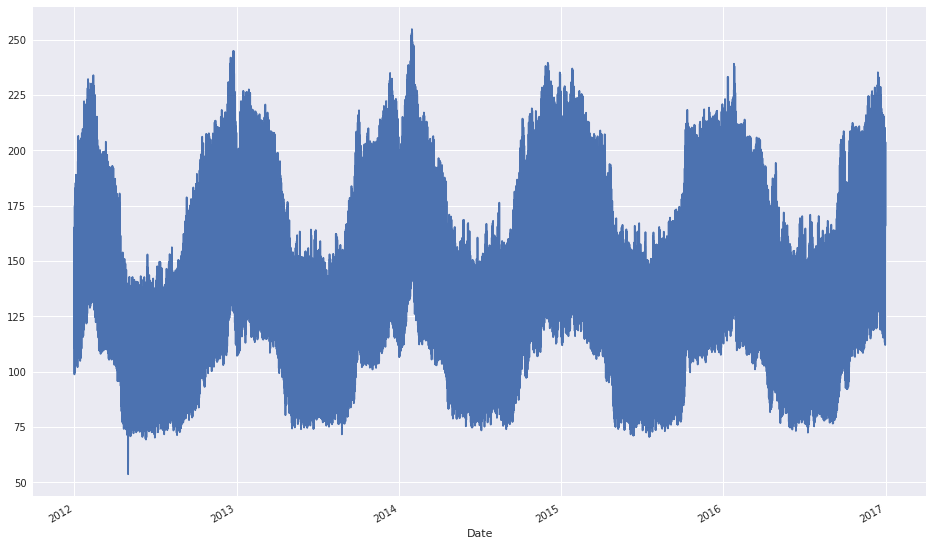

In [4]:
ts.plot(figsize=(16, 10));

/home/dawg/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


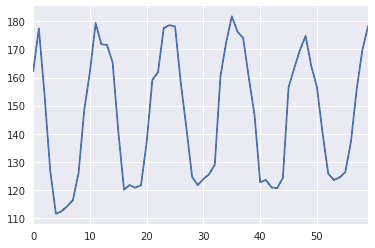

In [5]:
sns.tsplot(data=mon, err_style="boot_traces", n_boot=500);

count    43849.000000
mean       146.443277
std         37.913310
min         53.735000
25%        119.496000
50%        143.821000
75%        175.947000
max        254.733000
Name: MWh, dtype: float64

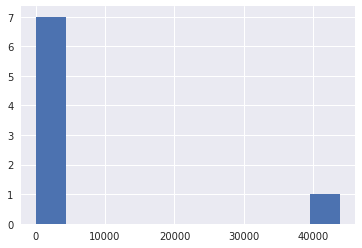

In [6]:
desc = ts.describe()
desc.hist()
desc

In [7]:
import statsmodels as sm
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.stattools import jarque_bera 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA

In [8]:
day_freq = ts.resample('D').mean()

In [9]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = jarque_bera(ts)
a = np.vstack([jb_test])
jb_table = SimpleTable(a, row)
jb_table

JB,p-value,skew,kurtosis
1110.73752566,6.40340369364e-242,0.104256086027,2.2486905719


In [10]:
def adf(data):
    test = adfuller(data)
    print('adf: ', test[0] )
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')
adf(day_freq)

adf:  -3.03572899738
p-value:  0.0316898157966
Critical values:  {'1%': -3.4339780465948548, '5%': -2.8631425806072164, '10%': -2.5676231613477491}
единичных корней нет, ряд стационарен


In [11]:
# ARMA 

model = ARMA(day_freq.resample('M').mean(), order=(1,1,1)).fit(full_output=True, disp=0)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                    MWh   No. Observations:                   60
Model:                     ARMA(1, 1)   Log Likelihood                -230.580
Method:                       css-mle   S.D. of innovations             11.143
Date:                Thu, 05 Jul 2018   AIC                            469.160
Time:                        20:18:33   BIC                            477.537
Sample:                    01-31-2012   HQIC                           472.437
                         - 12-31-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        148.4450      7.633     19.447      0.000     133.484     163.406
ar.L1.MWh      0.7391      0.091      8.113      0.000       0.561       0.918
ma.L1.MWh      0.4480      0.090      4.995      0.0

Text(0.5,1,'RSS: 7648.7469')

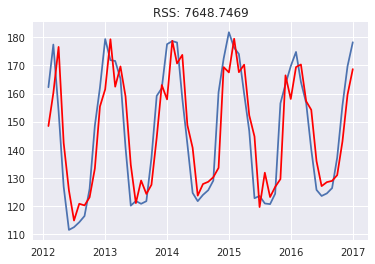

In [12]:
plt.plot(day_freq.resample('M').mean())
plt.plot(model.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((model.fittedvalues-day_freq.resample('M').mean())**2))


In [13]:
from sklearn.metrics import r2_score

print('R_sqaured: {:.2f}'.format(r2_score(day_freq.resample('M').mean(), model.fittedvalues)))


R_sqaured: 0.75


In [14]:
rng = pd.date_range('1/1/2017', periods=12, freq='M')
predict_start, predict_end = rng.values[0], rng.values[-1]

In [15]:
preds = model.predict(start=predict_start, end=predict_end)

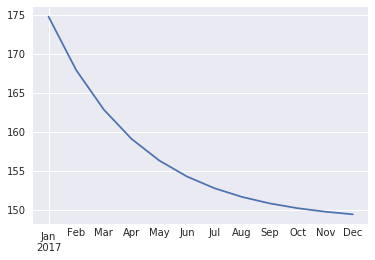

In [16]:
preds.plot()

# predict are ok just for 6 month interval

In [17]:
# keras build
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler



Using TensorFlow backend.


In [18]:
values = ts.values.reshape(ts.size, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

In [19]:
window_size = 50
series = scaled.copy()

for i in range(window_size):
    series = pd.concat([series, scaled.shift(-(i+1))], axis=1)

series.dropna(axis=0, inplace=True)    

In [20]:
series

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.061603,-0.159793,-0.268520,-0.346063,-0.401307,-0.433497,-0.431557,-0.413636,-0.378262,-0.375944,...,0.041055,0.190012,0.206390,0.177216,0.115245,0.007582,-0.146529,-0.299973,-0.405278,-0.463368
1,-0.159793,-0.268520,-0.346063,-0.401307,-0.433497,-0.431557,-0.413636,-0.378262,-0.375944,-0.319824,...,0.190012,0.206390,0.177216,0.115245,0.007582,-0.146529,-0.299973,-0.405278,-0.463368,-0.523329
2,-0.268520,-0.346063,-0.401307,-0.433497,-0.431557,-0.413636,-0.378262,-0.375944,-0.319824,-0.267893,...,0.206390,0.177216,0.115245,0.007582,-0.146529,-0.299973,-0.405278,-0.463368,-0.523329,-0.542712
3,-0.346063,-0.401307,-0.433497,-0.431557,-0.413636,-0.378262,-0.375944,-0.319824,-0.267893,-0.239575,...,0.177216,0.115245,0.007582,-0.146529,-0.299973,-0.405278,-0.463368,-0.523329,-0.542712,-0.511617
4,-0.401307,-0.433497,-0.431557,-0.413636,-0.378262,-0.375944,-0.319824,-0.267893,-0.239575,-0.234361,...,0.115245,0.007582,-0.146529,-0.299973,-0.405278,-0.463368,-0.523329,-0.542712,-0.511617,-0.406422
5,-0.433497,-0.431557,-0.413636,-0.378262,-0.375944,-0.319824,-0.267893,-0.239575,-0.234361,-0.234918,...,0.007582,-0.146529,-0.299973,-0.405278,-0.463368,-0.523329,-0.542712,-0.511617,-0.406422,-0.295336
6,-0.431557,-0.413636,-0.378262,-0.375944,-0.319824,-0.267893,-0.239575,-0.234361,-0.234918,-0.220888,...,-0.146529,-0.299973,-0.405278,-0.463368,-0.523329,-0.542712,-0.511617,-0.406422,-0.295336,-0.134887
7,-0.413636,-0.378262,-0.375944,-0.319824,-0.267893,-0.239575,-0.234361,-0.234918,-0.220888,-0.167454,...,-0.299973,-0.405278,-0.463368,-0.523329,-0.542712,-0.511617,-0.406422,-0.295336,-0.134887,-0.041543
8,-0.378262,-0.375944,-0.319824,-0.267893,-0.239575,-0.234361,-0.234918,-0.220888,-0.167454,-0.007911,...,-0.405278,-0.463368,-0.523329,-0.542712,-0.511617,-0.406422,-0.295336,-0.134887,-0.041543,0.024667
9,-0.375944,-0.319824,-0.267893,-0.239575,-0.234361,-0.234918,-0.220888,-0.167454,-0.007911,0.109096,...,-0.463368,-0.523329,-0.542712,-0.511617,-0.406422,-0.295336,-0.134887,-0.041543,0.024667,0.047264


In [21]:
model = Sequential()
model.add(LSTM(input_shape = (50, 1), output_dim=50, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

/home/dawg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(series, shuffle=False)

In [23]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

train_X = train_X.values.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.values.reshape(test_X.shape[0],test_X.shape[1],1)

In [24]:
import time 

start = time.time()
model.fit(train_X, train_y, batch_size=512, nb_epoch=3, validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

/home/dawg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 29564 samples, validate on 3285 samples
Epoch 1/3
29564/29564 [==============================] - 348s 12ms/step - loss: 0.0584 - val_loss: 0.0215
Epoch 2/3
29564/29564 [==============================] - 348s 12ms/step - loss: 0.0204 - val_loss: 0.0112
Epoch 3/3
29564/29564 [==============================] - 397s 13ms/step - loss: 0.0144 - val_loss: 0.0087
> Compilation Time :  1096.425546169281


In [25]:
from sklearn.metrics import mean_squared_error as mse
preds = model.predict(test_X)
preds = scaler.inverse_transform(preds)

In [26]:
actuals = test_y.values.reshape(test_y.size, 1)
actuals = scaler.inverse_transform(actuals)
mse(actuals, preds)

87.294701991808182

/home/dawg/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


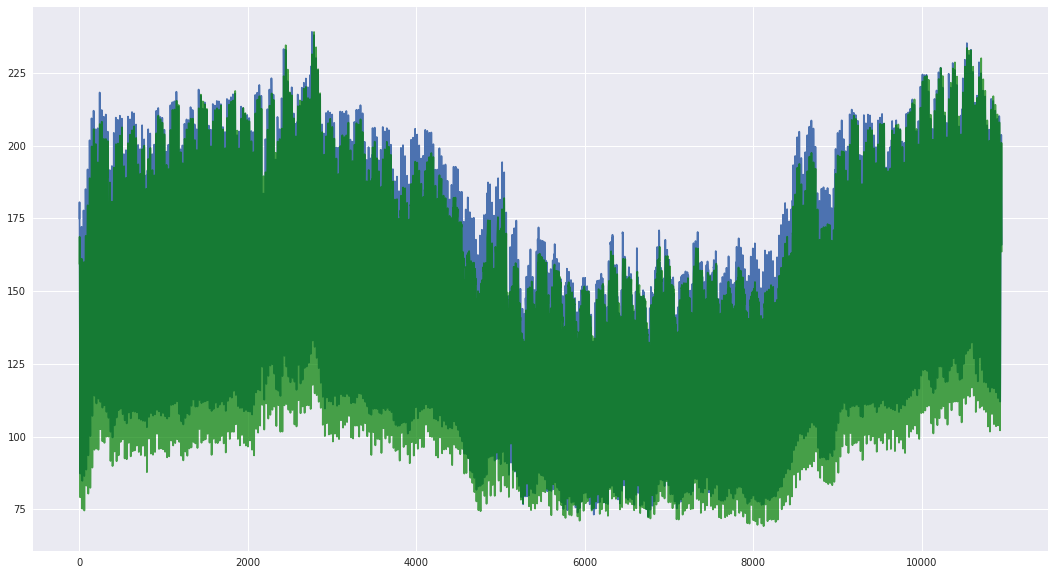

In [27]:
f = plt.figure(figsize=(40, 10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(121)

ax.plot(actuals)
ax2.plot(preds, color='green', alpha=0.7)



In [30]:
from sklearn.metrics import r2_score

print(f'R_squared: {r2_score(actuals, preds):.2f}')

R_squared: 0.94
